In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import itertools
from numba import njit
from sklearn.linear_model import LinearRegression
from scipy.ndimage import convolve, generate_binary_structure
from collections import deque

# Fractal structure

In [2]:
#Auxiliary functions
def connect_vertices(vertices, neighbors):
    combinaciones= list(itertools.combinations(vertices, 2))
    for c in combinaciones:
        if c[1] not in neighbors[c[0]]:
            neighbors[c[0]].append(c[1])
        if c[0] not in  neighbors[c[1]]:
            neighbors[c[1]].append(c[0])

In [3]:
def Triangle_Structure(num_iterations):

    # Initial triangle neighbors
    
    neighbors = {0: [1, 2], 1: [0, 2], 2: [0, 1]} 
    
    # Initial triangle vertices
    vertices= [0,1,2]
    
    n_vertices_it= [1, 3, 6, 15, 42, 123, 366, 1095]

    for i in range(num_iterations):

        new_neighbors = {}

        for key, value in neighbors.items():

            #Me aseguro de no contar doble
            if key < n_vertices_it[i]:
                
                #sub_tr será una lista con los vértices de cada subtriángulo 
                sub_tr= value
                sub_tr.sort()
                
                #Cada vértice solo puede tener 2 o 4 vecinos.
                #Es decir, hace parte de uno o dos subtriángulos.
                
                if len(sub_tr) > 2:
                    half = len(sub_tr) // 2
                    combination = [sub_tr[:half], sub_tr[half:]]
                    sub_tr= combination
                else:
                    sub_tr = [sub_tr]
                for c_ in sub_tr:
                    new_vertices= []
                    c_.insert(0, key)
                    # ej: c_=[0,1,2] 
                    
                    combinations = list(itertools.combinations(c_, 2))
                    #Combinatios es una lista de cada arista del triangulo
                    #ej: [[0,1],[0,2][1,2]]
                    for c in combinations:
                        #Creación nuevo vértice
                        midpoint = len(vertices) 
                        if midpoint not in vertices:
                            vertices.append(midpoint)
                            new_vertices.append(midpoint)

                            if midpoint not in new_neighbors:
                                new_neighbors[midpoint] = []
                            new_neighbors[midpoint].append(c[0])
                            new_neighbors[midpoint].append(c[1])

                            if c[0] not in new_neighbors:
                                new_neighbors[c[0]] = []
                            new_neighbors[c[0]].append(midpoint)

                            if c[1] not in new_neighbors:
                                new_neighbors[c[1]] = []
                            new_neighbors[c[1]].append(midpoint)
                    #Creo los enlaces entre 
                    connect_vertices(new_vertices, new_neighbors)

        neighbors.update(new_neighbors)
    return neighbors

In [4]:
neighbors= Triangle_Structure(4)
neighbors

{0: [42, 43],
 1: [45, 46],
 2: [48, 49],
 3: [51, 52, 54, 55],
 4: [57, 58, 60, 61],
 5: [63, 64, 66, 67],
 6: [69, 70, 72, 73],
 7: [75, 76, 78, 79],
 8: [81, 82, 84, 85],
 9: [87, 88, 90, 91],
 10: [93, 94, 96, 97],
 11: [99, 100, 102, 103],
 12: [105, 106, 108, 109],
 13: [111, 112, 114, 115],
 14: [117, 118, 120, 121],
 15: [42, 44, 69, 71],
 16: [43, 44, 75, 77],
 17: [70, 71, 76, 77],
 18: [45, 47, 87, 89],
 19: [46, 47, 93, 95],
 20: [88, 89, 94, 95],
 21: [48, 50, 105, 107],
 22: [49, 50, 111, 113],
 23: [106, 107, 112, 113],
 24: [51, 53, 72, 74],
 25: [52, 53, 81, 83],
 26: [73, 74, 82, 83],
 27: [54, 56, 90, 92],
 28: [55, 56, 99, 101],
 29: [91, 92, 100, 101],
 30: [57, 59, 78, 80],
 31: [58, 59, 84, 86],
 32: [79, 80, 85, 86],
 33: [60, 62, 108, 110],
 34: [61, 62, 117, 119],
 35: [109, 110, 118, 119],
 36: [63, 65, 96, 98],
 37: [64, 65, 102, 104],
 38: [97, 98, 103, 104],
 39: [66, 68, 114, 116],
 40: [67, 68, 120, 122],
 41: [115, 116, 121, 122],
 42: [0, 15, 43, 44],


In [5]:
N=len(neighbors)
#Neighbors es un diccionario donde la llave corresponde al índice del spin,
#y el valor a una lista con los índices de sus vecinos.
N

123

# Spin assignation

In [6]:
init_random = np.random.random(N)

init_random[init_random >= 0.5]= 1
init_random[init_random <= 0.5]= -1

spins= init_random

In [7]:
def get_total_energy(neighbors, spins):
    total=0
    for key in neighbors:
        for j in neighbors[key]:
            total+= spins[key]*spins[j]
        
    return -total

In [8]:
get_total_energy(neighbors, spins)

-30.0

In [9]:
#Cambio en la energía al voltear un spin

def get_energy_change(neighbors, spins, spin):
    l_neighbors= neighbors[spin]
    sum_=0
    for i in l_neighbors:
        sum_+= spins[i]*spins[spin]
        
    return sum_

In [10]:
def metropolis(neighbors, spins, times, BJ, energy):
    
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    
    #Correlaciones
    corr= np.zeros((times-1, N))
    
    for t in range(0,times-1):
        c_spins = spins.copy()
        #Escoger un punto aleatorio y voltear el spin.
        x = np.random.randint(0,N)
        spin_f= spins[x]*-1
        c_spins[x]= spin_f #proposed spin flip
        
        # Calcular cambio en energía
        E_i = get_energy_change(neighbors, spins, x)
        E_f = get_energy_change(neighbors, c_spins, x)
        
        
        # 3 / 4. Cambiar el estado de acuerdo a las probabilidades
        
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spins[x]= spin_f
            energy += dE
        elif dE<=0:
            spins[x]= spin_f
            energy += dE
            
       
        corr[t]= spins
        net_spins[t] = spins.sum()
        net_energy[t] = energy
        
    return net_spins, net_energy, corr

In [11]:
spins_, energies, corr = metropolis(neighbors, spins, 100000, 0.5, get_total_energy(neighbors, spins))

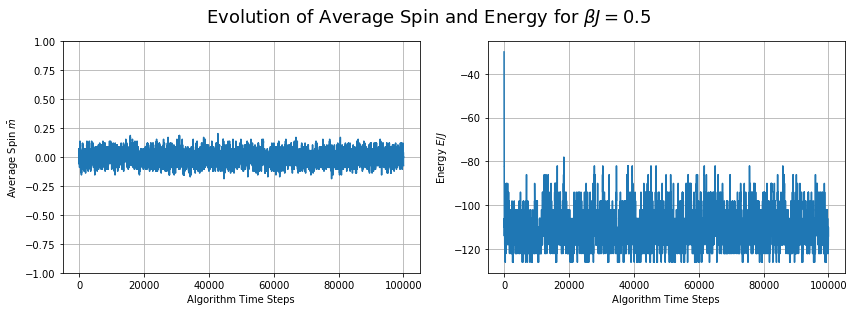

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins_/N)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax.set_ylim(-1,1)

ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.5', y=1.07, size=18)
plt.show()

In [73]:
def get_spin_energy(neighbors, spins, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    t_corrs= []
    for i, bj in enumerate(BJs):
        spins_, energies, corrs= metropolis(neighbors, spins, 100000, bj, get_total_energy(neighbors,spins))
        ms[i] = spins_[-100000:].mean()/N
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
        t_corrs.append(corrs)
    return ms, E_means, E_stds, np.array(t_corrs)

BJs = np.arange(0.1, 2.0, 0.05)
#BJs= np.arange(0.1, 0.75, 0.05)
ms_p, E_means_p, E_stds_p, t_corrs= get_spin_energy(neighbors,spins, BJs)

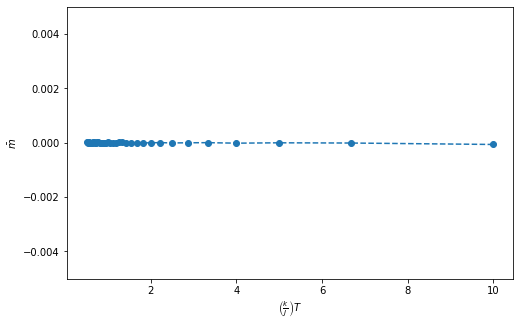

In [75]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_p/N, 'o--')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.axis([None, None, -0.005, 0.005])
plt.show()
#plt.savefig("isingm.jpg")

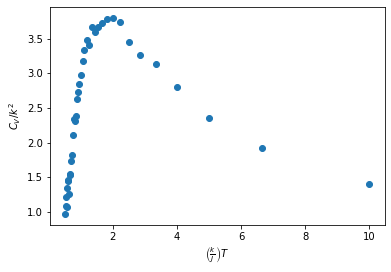

In [76]:
plt.scatter(1/BJs, E_stds_p*BJs)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.show()
#plt.savefig("ising2d.jpg")

# Correlation function

In [65]:
#Correlacion para un spin i, j 
def correlation_function(corr, i, j):
    
    si= np.mean(corr[:,i])
    sj= np.mean(corr[:,j])
    sisj= np.mean(corr[:,i]*corr[:,j])
    corr_i= abs(sisj- (si*sj))
    
    return corr_i

In [31]:
#Encontrar menor distancia entre spines
#Busqueda de anchura BFS para recorrer grafos.

def min_distance(graph, start, end):
    # Crea un queue en el que en la que los elementos se agregan y eliminan 
    #en el mismo orden en el que fueron agregados.
    
    #Distancia de un vértice a si mismo.
    queue = deque([(start, 0)])
    
    # Guardo los que ya he visitado
    visited = set()
    
    # Iterar hasta vaciar queue
    
    while queue:
        vertex, distance = queue.popleft()
        if vertex == end:
            return distance
    
        if vertex in visited:
            continue
        visited.add(vertex)
        
        # Añadir vertice a queue
        for neighbor in graph[vertex]:
            queue.append((neighbor, distance + 1))
            
    return distance

In [41]:
def correlation_distance(corr, neighbors, n):
    
    #Diferentes distancias de separación
    rs = np.arange(1,6,1)
    i= np.random.randint(0,N)
    corr_=[]
    for r in rs:
        cond= True
        k=0
        while cond:
            r_= min_distance(neighbors, i, k)
            if r == r_:
                corr_.append(correlation_function(corr, i, k))
                cond= False
            k+=1
    x= np.log(rs)
    y= np.log(corr_)
    if n%3 == 0:
        plt.plot(rs, corr_, "o--", label= r"$T= {:.2f}$".format(1/BJs[n]))
    plt.legend()
    plt.title("Correlations", fontsize=15, fontweight='bold')
    plt.xlabel(r"$r$ (distance)")
    plt.ylabel("Correlation function")
    modelo = LinearRegression()
    modelo.fit(x.reshape(-1, 1), y)
    length= -modelo.coef_ 
    return length

# Correlation length

In [39]:
def correlation_length(t_corr):
    lengths=[]
    #Para cada temperatura
    for i in range(len(t_corr)):
        l_= correlation_distance(t_corr[i], neighbors, i)
        lengths.append(l_)
    return lengths

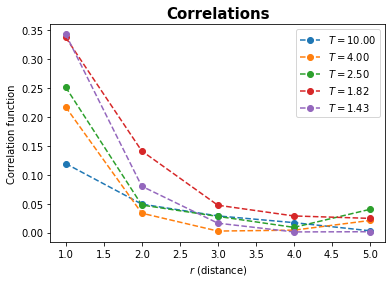

In [66]:
y= correlation_length(t_corrs)

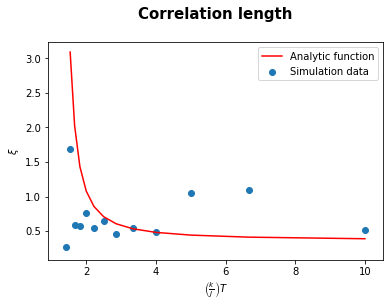

In [70]:
BJs_ = np.arange(0.1, 0.7, 0.05)
t= lambda x: np.exp(-4*x)
epsilon= lambda x: 2**(1/(4*t(x)))
plt.plot(1/BJs_, ((0.3)*epsilon(BJs_)), c="r", label= "Analytic function")                       
plt.scatter(1/BJs, [1/n for n in y], label= "Simulation data")
plt.title("Correlation length\n", fontsize=15, fontweight='bold')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r"$\xi$")
plt.legend()